In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning

from jas1101finalproject.fit import sigmar_2
from jas1101finalproject.fit import set_prior, set_likelihood
from jas1101finalproject.fit import DynamicNestedSampler

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

In [4]:
from jas1101finalproject.data import load_summary_table
summary = load_summary_table()
catalog = summary[summary['nstar']>2000]
catalog.sort('nstar')
catalog

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_6352,261.371,-48.422,5.6,-125.6,1.0,3.5,10.0,-2.172,-4.398,0.056,0.056,0.003,2064.3,5.36,0.138,0.208,0.002,4.905098164155331,"-0.5575897528143013,-3.6743112718598936,-4.189096602495557"
NGC_4372,186.439,-72.659,5.8,75.6,0.3,4.7,15.0,-6.378,3.358,0.05,0.05,0.001,2189.9,7.79,0.175,0.216,0.015,7.207985016632596,"-1.7178312698669347,-0.19386974276312463,-5.53637699683722"
NGC_7078_M_15,322.493,12.167,10.4,-106.8,0.2,13.6,15.0,-0.643,-3.763,0.051,0.051,0.001,2198.4,9.92,0.15,0.253,0.004,3.817540831477772,"8.064782846161782,-6.189891110876883,2.191922827049806"
NGC_6366,261.934,-5.0798,3.5,-120.7,0.2,2.9,12.0,-0.363,-5.115,0.053,0.053,0.015,2226.3,6.17,0.173,0.323,0.003,5.127864467787736,"-0.489169139412986,-3.451764034498839,-0.30990095705927495"
NGC_288,13.1885,-26.582,8.9,-44.8,0.1,3.3,12.0,4.267,-5.636,0.054,0.053,0.018,2555.2,6.05,0.082,0.245,0.014,7.069072428543932,"7.7492974589059225,1.8159404374775876,-3.9825556142919"
NGC_6838_M_71,298.443,18.7791,4.0,-22.3,0.2,2.9,10.0,-3.415,-2.614,0.054,0.054,0.005,2676.4,5.1,0.146,0.203,0.007,4.300607050173266,"1.8037203450521444,-3.3299353471609288,1.2876814437481026"
NGC_6362,262.979,-67.048,7.6,-14.6,0.2,3.7,12.0,-5.51,-4.75,0.051,0.052,-0.0,2877.0,6.49,0.109,0.182,0.026,7.2747920932491255,"-0.36226165897029655,-2.941471207269782,-6.998322200873788"
NGC_6218_M_12,251.809,-1.9485,4.8,-41.4,0.2,5.0,15.0,-0.141,-6.802,0.052,0.051,0.019,3356.7,6.77,0.184,0.298,0.043,6.803461251451352,"-1.497624889423507,-4.5574646013839075,-0.16320569141989863"


In [8]:
GCs = [GlobularCluster.from_name(name) for name in catalog[:-2]['Name']]

In [30]:
r_all, pm_all, pm_e_all = np.array([]), np.array([]), np.array([])
for gc in GCs:
    r = gc.r
    pm = gc.pm - gc.pm.mean()
    pm_e = gc.pm_e
    
    good = pm_e < 2
    p = sns.distplot(gc.r[good], color='blue')
    x_kde, y_kde = p.get_lines()[0].get_data()

    x_peak = x_kde[np.argmax(y_kde)]
    y_sol = y_kde.max()*0.85
    left, right = x_kde<x_peak, x_kde>x_peak
    x_left, x_right = [x_kde[side][np.argmin(abs(y_kde-y_sol)[side])] for side in (left, right)]

    plt.close()

    r_min, r_max = x_left, x_right
    print("r: {0:.3f} ~ {1:.3f}".format(r_min, r_max))
#     cond = (r>r_min) & (r<r_max) & good
    cond = (r>0.5) & (r<0.7) & good
    
    r_all = np.append(r_all, r[cond])
    pm_all = np.append(pm_all, pm[cond])
    pm_e_all = np.append(pm_e_all, pm_e[cond])


r: 0.254 ~ 0.610
r: 0.312 ~ 0.738
r: 0.223 ~ 0.419
r: 0.286 ~ 0.672
r: 0.381 ~ 0.693
r: 0.291 ~ 0.714
r: 0.402 ~ 0.689
r: 0.452 ~ 0.742
r: 0.326 ~ 0.751
r: 0.471 ~ 0.742
r: 0.489 ~ 0.860
r: 0.426 ~ 0.737
r: 0.423 ~ 0.748
r: 0.482 ~ 0.773
r: 0.332 ~ 0.652
r: 0.389 ~ 0.911
r: 0.440 ~ 0.779
r: 0.352 ~ 0.780


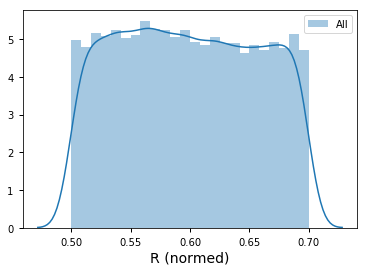

In [31]:
sns.distplot(r_all, label="All")
plt.xlabel("R (normed)")
plt.legend()

Text(0, 0.5, 'PM (normed)')

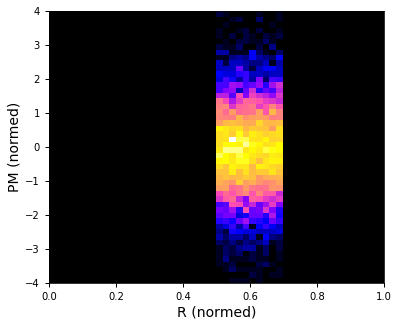

In [32]:
# display r-pm hist2d
fig, (ax) = plt.subplots(1,1,figsize=(6,5))
H, xb, yb, _ = ax.hist2d(r_all, pm_all, bins=50, range=[[0,1],[-4,4]], norm=AsinhNorm(), cmap="gnuplot2")

ax.set_xlabel("R (normed)") # normalized
ax.set_ylabel("PM (normed)") # normalized

Text(0, 0.5, '$\\sigma_r$ (normed)')

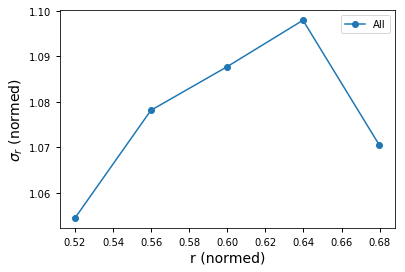

In [37]:
bins=np.linspace(0.5, 0.7, 6)

r_rbin, z_rbin, z_bins = profile_binning(r_all, pm_all, bins=bins, plot=False)
plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-', label="All")

plt.legend()
plt.xlabel("r (normed)")
plt.ylabel("$\sigma_r$ (normed)")

In [1]:
10**-2.4

0.0034673685045253167

In [12]:
7e5 * 10**(-2.48)

2317.9178503781377

In [10]:
1e6 * 10**(-5.65)

2.2387211385683377

In [14]:
7e4 * 10**(-1.29), 7e4 * 10**(-5.83)

(3590.0296879395537, 0.1035375871717745)